# Evaluating Regressors



In [127]:
# Setup
from mlwpy import *
%matplotlib inline

diabetes = datasets.load_diabetes()

tts = skms.train_test_split(diabetes.data,
                            diabetes.target,
                            test_size=.25,
                            random_state=42)

(diabetes_train_ftrs, diabetes_test_ftrs,
 diabetes_train_tgt,  diabetes_test_tgt) = tts

# 7.1 BaselineRegressors

Regressors, like classifiers need simple baseline strategies to compete against.  In `sklearn`s back of tricks, we can easily create baseline models that predict the mean and the median, which are fixed values for a given training dataset.  Once we train on the dataset, the baseline returns a single value which serves as our prediction for all examples.  Another approach is to pick arbirary constants out of ahat.  For example, if a rare disease causes fever and most people are healthy, a temperature near 98.6 degrees Fahrenheit could be a good baseline temperature prediction.

The `quantile` generalizes the idea of the `median`.  The median is a specific percentile--the 50th percentile.  The 75th percentile has 75% of the data less than it and 25% of the data greater.

Using `quantile`, we can pick an arbitrary percent as our break point. 

In [128]:
baseline = dummy.DummyRegressor(strategy='median')
strategies = ['constant', 'quantile', 'mean', 'median', ]
baseline_args = [{'strategy':s} for s in strategies]

# additional args for constant and quantile
baseline_args[0]['constant'] = 50.0
baseline_args[1]['quantile'] = 0.75
baseline_args

[{'strategy': 'constant', 'constant': 50.0},
 {'strategy': 'quantile', 'quantile': 0.75},
 {'strategy': 'mean'},
 {'strategy': 'median'}]

In [129]:
# similar to ch 5, but using a list comprehension
# process a single argument package (a dict)

def do_one(**args):
    baseline = dummy.DummyRegressor(**args)
    baseline.fit(diabetes_train_ftrs, diabetes_train_tgt)
    base_preds = baseline.predict(diabetes_test_ftrs)
    return metrics.mean_squared_error(base_preds, diabetes_test_tgt)

# gather all results via a list comprehension
mses = [do_one(**bla) for bla in baseline_args]

display(pd.DataFrame({'mse':mses}, index=strategies))

,mse
constant,"14,657.6847"
quantile,"10,216.3874"
mean,"5,607.1979"
median,"5,542.2252"


# 7.2 Additional Measures for Regression

So far, we used *mean squared error* as our success measure in regression problems.  We have also modified MSE to the *root mean squared error* (RMSE) because the scale of MSE is a bit off compared to our predictions.  MSE is on the same scale as the squares of the errors; RMSE moves us back to the scale of the errors.  We've done this in an ad-hoc manner by applying square roots here and there.  However, RMSE is more commonly use, let's integrate RMSE more deeply into our `sklearn`-fu. (Seriously, what???) (what is `sklearn`-fu?)


We develop the new regression evaluation metric in three steps.  We define an error measure, use the error to define a score, and use the score to create a scorer.  This is because, generally, `sklearn` wants to work with scores, where bigger is better.

Remember: (1) for *errors* and *loss functions*, lower values are better and (2) for *scores*, higher values are better.  Therefore, we need an inverse relationship between our error measure and our score.  One of the easiest ways to do that is to negate the error.  Therefore, for RMSE, all our scores based on it will be negative, and being *better* means being closer to zero while still negative.  A way to think about this is like losing *less* money.

The error and scoring functions have to receive three arguments: a fit model, predictors, and a target.  `sklearn` has a naming convention that "smaller is better" ends with `_error` or `_loss` and "bigger is better" ends with `_score`.  The `*_scorer` form is responsible for applying a model on features to make predictions and compare them with actual known values.  It quantifies the success using an error or score function.

It is not necessary to define all three of these pieces.  We could pick and choose which RMS components we want to implement.  However, writing code for all three demonstrates how they are related.

## 7.2.1 Creating Our Own Evaluation Metric

In [130]:
def rms_error(actual, predicted):
    'root-mean-squared-error function '
    # lesser values are better (a < b means a is better)
    mse = metrics.mean_squared_error(actual, predicted)
    return np.sqrt(mse)

def neg_rmse_score(actual, predicted):
    ' rmse based score function '
    # greater values are better (a < b means b is better)
    return -rms_error(actual, predicted)

def neg_rmse_scorer(mod, ftrs, tgt_actual):
    ' rmse scorer suitable for scoring arg '
    tgt_pred = mod.predict(ftrs)
    return neg_rmse_score(tgt_actual, tgt_pred)

knn = neighbors.KNeighborsRegressor(n_neighbors=3)
skms.cross_val_score(knn,
                     diabetes.data, diabetes.target,
                     cv=skms.KFold(5, shuffle=True),
                     scoring=neg_rmse_scorer)

array([-59.9545, -60.4838, -62.1117, -72.6665, -68.2894])

The `hand_and_till_M_statistic` from earlier acted like a score and we turned it into a scorer with `make_scorer`.
Here, we laid out all the `sklearn` subcomponents for RMSE: an error measure, a score, and a scorer.  `make_scorer` can be told to treat larger values as the *better* result with the `greater_is_better` argument.

## 7.2.2 Other Built-in Regression Metrics

The laundry list of metrics is available through `metrics.SCORERS.keys().`  We can check out the default metric for linear regression by looking at `help(lr.score)`.

In [131]:
metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [132]:

lr = linear_model.LinearRegression()

#help(lr.score) # for full output
print(lr.score.__doc__.splitlines())
print(lr.score.__doc__.splitlines()[0])

['Return the coefficient of determination :math:`R^2` of the', '        prediction.', '', '        The coefficient :math:`R^2` is defined as :math:`(1 - \\frac{u}{v})`,', '        where :math:`u` is the residual sum of squares ``((y_true - y_pred)', '        ** 2).sum()`` and :math:`v` is the total sum of squares ``((y_true -', '        y_true.mean()) ** 2).sum()``. The best possible score is 1.0 and it', '        can be negative (because the model can be arbitrarily worse). A', '        constant model that always predicts the expected value of `y`,', '        disregarding the input features, would get a :math:`R^2` score of', '        0.0.', '', '        Parameters', '        ----------', '        X : array-like of shape (n_samples, n_features)', '            Test samples. For some estimators this may be a precomputed', '            kernel matrix or a list of generic objects instead with shape', '            ``(n_samples, n_samples_fitted)``, where ``n_samples_fitted``', '            

The default metric for linear regression is $R^2$.  $R^2$ is the default metric for all regressors.  The other major built-in performance evaluation metrics for regressors are mean absolute error, mean squared error, and median absolute error.

In both mean absolute error (MAE) and mean squared error (MSE), the mean part means to divide by the number of examples.  MAE penalizes large and small differences from *actual* by the same amount as the size of the error.  Therefore, if we are off by 10 we get a penalty of 10.  However, MSE penalizes bigger errors more: being off by 10 generates a penalty of 100.  If two predictions are off by 5, the contributes to MAE are $5 + 5 = 10$.  However, with MSE, the contributions from two errors of 5 are $5^2 + 5^2 = 25 + 25 = 50$.  Therefore, with MAE, we could have 10 data points off by 5, two points off by 25, or one point off by 50.  For MSE, we could only have one point off by about 7 since $7^2$ = 49.

Median absolute error protetcs from single large errors overwhelming other well-behaved errors.  If we are OK with a few real bad errors, as long  as the rest of the predictions are on track, MAE may be a good fit.

## 7.2.3 $R^2$

Let's define $R^2$ in the manner the `sklearn` computes it.  We describe $R^2$ in terms of two models.  The first is *our model of interest*.  From it, we can calculate how well we do with our model using the *sum of squared errors.*

$$ SSE_{ours} = \Sigma_i(our\_preds_{i} - actual_{i})^2 $$ 

$$ SSE_{mean} = \Sigma_i(mean - actual_{i})^2 $$



In [133]:
our_preds  = np.array([1, 2, 3])
mean_preds = np.array([2, 2, 2])
actual     = np.array([2, 3, 4])

sse_ours = np.sum((our_preds - actual)**2)
sse_mean = np.sum((mean_preds - actual)**2)

With these two components, we can compute $R^2$ just like `sklearn` describes in its documentation.

In [134]:
r_2 = 1 - (sse_ours / sse_mean)
print(f'manual r2:{r_2:5.2f}')

manual r2: 0.40


The formula referenced by the `sklearn` docs is:

$$ R^2 = 1 - \frac{SSE_{ours}}{SSE_{mean}} $$

$\frac{SSE_{ours}}{SSE_{mean}}$ is the ratio between how well we do versus how well a simple model does, when both models are measured in terms of the sum of squared errors.  The specific baseline model is the `dummy.DummyRegressor(strategy='mean')` that we saw at the start of the chapter.  For example, if the errors of our predictor were 2500 and the errors o fthe mean were 10000, the ratio between the two would be \frac{1}{4} and we would ahve $R^2 = 1 - \frac{1}{4} = \frac{3}{4} = 0.75$  We are *normalizing* or rescaling, our model's performance to a model that always predicts the mean target value.  What is the *one minus* that ratio?

### 7.2.3.1 An Interpretation of $R^2$ for the Machine Learning World

The term $\frac{SSE_{ours}}{SSE_{mean}}$ will be between zero and one.  If the linear regression uses only a constant term it will be identical to the mean and the value will be 1.  At the low end, if there linear regression makes no errors on the data, it will be zero.  

However, our model could be *worse* than the mean.  If we have a worse-than-mean model, and we use `sklearn`'s formula for $R^2$, then we have a *negative* value.  

How can we think about `sklearn`'s $R^2$ in a reasonable way?  The ratio between the SSEs gives us a normalized performance versus a standard, baseline model.  Under the hood, the SSE is the same as our mean squared error but without the mean.  If we divide both SSEs in the ratio by *n*, we get

$$ R^2 = 1 - \frac{\frac{SSE_{ours}}{n}}{\frac{SSE_{mean}}{n}} = 1 - \frac{MSE_{ours}}{MSE_{mean}} $$


We have really been working with ratios of MSEs in disguise.  To ease our interpration of the right-hand side, let's get ride of the 1-.

$$ R^2 = 1 - \frac{SSE_{ours}}{SSE_{mean}} = 1 - \frac{MSE_{ours}}{MSE_{mean}} $$


$$ 1 - R^2 = \frac{SSE_{ours}}{SSE_{mean}} = \frac{MSE_{ours}}{MSE_{mean}} $$

We can view $ 1 - R^2 $ (for arbitrary machine learning models) as a MSE that is normalized by the MSE we get from a simple, baseline model that predicts the mean.  If we have two models of interest and if we compare (divide) the $ 1 - R^2 $ of our model 1 and the $1 - R^2 $ of our model 2, we get:

$$ \frac{1 - R^2_{M1}}{1 - R^2_{M2}} = \frac{\frac{MSE_{M1}}{MSE_{mean}}}{\frac{MSE_{M2}}{MSE_{mean}}} = \frac{MSE_{M1}}{MSE_{M2}} $$

This is the ratios of MSEs or SSEs between the two models.

### 7.2.3.2 A Cold Dose of Reality: sklearn's $R^2$

Let's compute a few simple $R^2$ values manually and with `sklearn`.  We compute `r2_score` from actuals and test set predictions from a simple predict-the-mean model:

In [135]:
baseline = dummy.DummyRegressor(strategy='mean')

baseline.fit(diabetes_train_ftrs, diabetes_train_tgt)
base_preds = baseline.predict(diabetes_test_ftrs)

# r2 is not symmetric because true values have priority
# are are used to compute target mean
base_r2_sklearn = metrics.r2_score(diabetes_test_tgt, base_preds)
print(base_r2_sklearn)

-0.014016723490579253


Now, let's look at those values with some manual computations:

In [136]:
# sklearn-train-mean to predict test tgts
base_errors = base_preds - diabetes_test_tgt
sse_base_preds = np.dot(base_errors, base_errors)

# train-mean to predict test targets
train_mean_errors = np.mean(diabetes_train_tgt) - diabetes_test_tgt
sse_mean_train = np.dot(train_mean_errors, train_mean_errors)

# test-mean to predict test targets (Danger Will Robinson!)
test_mean_errors = np.mean(diabetes_test_tgt) - diabetes_test_tgt
sse_mean_test    = np.dot(test_mean_errors, test_mean_errors)

print('sklearn train-mean model SSE(on test):', sse_base_preds)
print(' manual train-mean model SSE(on test):', sse_mean_train)
print(' manual test-mean model SSE(on test):', sse_mean_test)

sklearn train-mean model SSE(on test): 622398.970317905
 manual train-mean model SSE(on test): 622398.970317905
 manual test-mean model SSE(on test): 613795.5675675675


In the third option, we calculated the mean of the *test* set and looked at my error against the test targets.  Not surprisingly, since we are teaching to the test, we do a bit better than the other cases.  Let's see what happens if we use the taught-to-the-test values as our baseline for computing `r2`:

In [137]:
print(diabetes_test_tgt)
print(np.mean(diabetes_test_tgt))
print(test_mean_errors)
print(sse_mean_test)

[219.  70. 202. 230. 111.  84. 242. 272.  94.  96.  94. 252.  99. 297.
 135.  67. 295. 264. 170. 275. 310.  64. 128. 232. 129. 118. 263.  77.
  48. 107. 140. 113.  90. 164. 180. 233.  42.  84. 172.  63.  48. 108.
 156. 168.  90.  52. 200.  87.  90. 258. 136. 158.  69.  72. 171.  95.
  72. 151. 168.  60. 122.  52. 187. 102. 214. 248. 181. 110. 140. 202.
 101. 222. 281.  61.  89.  91. 186. 220. 237. 233.  68. 190.  96.  72.
 153.  98.  37.  63. 184. 144. 150. 280. 125.  59.  65. 281. 277. 167.
  90.  72. 178.  88. 270. 101. 197.  97.  53.  71. 262.  52. 102.]
145.54054054054055
[ -73.4595   75.5405  -56.4595  -84.4595   34.5405   61.5405  -96.4595
 -126.4595   51.5405   49.5405   51.5405 -106.4595   46.5405 -151.4595
   10.5405   78.5405 -149.4595 -118.4595  -24.4595 -129.4595 -164.4595
   81.5405   17.5405  -86.4595   16.5405   27.5405 -117.4595   68.5405
   97.5405   38.5405    5.5405   32.5405   55.5405  -18.4595  -34.4595
  -87.4595  103.5405   61.5405  -26.4595   82.5405   97.5405  

In [138]:
1 - (sse_base_preds / sse_mean_test)

-0.014016723490578809

Let's compare with the `r2` score we calculated above.

In [139]:
print(base_r2_sklearn)
print(1 - (sse_base_preds / sse_mean_test))

-0.014016723490579253
-0.014016723490578809


`sklearn`'s $R^2$ is calculating its base model--the mean model--from the true values we are testing against.  

We are not comparing the performance of `my_model.fit(train)` and `mean_model.fit(train)`.  With `sklearn`'s $R^2$ we are comparing `my_model.fit(train)` with `mean_model.fit(test)` and evaluating them against `test`.  Since this is counterintuitive, let's draw it out the long way:

In [140]:
# 
# WARNING! Don't try this at home, boys and girls!
# We are fitting on the *test* set... to mimic the behavior
# of sklearn R^2
#

testbase = dummy.DummyRegressor(strategy='mean')
testbase.fit(diabetes_test_ftrs, diabetes_test_tgt)
testbase_preds = testbase.predict(diabetes_test_ftrs)
testbase_mse = metrics.mean_squared_error(testbase_preds,
                                          diabetes_test_tgt)

models = [neighbors.KNeighborsRegressor(n_neighbors=3),
          linear_model.LinearRegression()]

results = co.defaultdict(dict)
for m in models:
    preds = (m.fit(diabetes_train_ftrs, diabetes_train_tgt)
              .predict(diabetes_test_ftrs))
        
    mse = metrics.mean_squared_error(preds, diabetes_test_tgt)
    r2 = metrics.r2_score(diabetes_test_tgt, preds)
    results[get_model_name(m)]['R^2'] = r2
    results[get_model_name(m)]['MSE'] = mse
    
print(testbase_mse)

df = pd.DataFrame(results).T
df['Norm_MSE'] = df['MSE'] / testbase_mse
df['1-R^2'] = 1-df['R^2']
display(df)


5529.689797906013


,R^2,MSE,Norm_MSE,1-R^2
KNeighborsRegressor,0.3722,"3,471.4194",0.6278,0.6278
LinearRegression,0.4849,"2,848.2953",0.5151,0.5151


Therefore, $1 - R^2$ computed by `sklearn` is equivalent to the MSE of our model normalized by the *fit-to-the-test-sample* mean model.  If we *knew* the mean of our test targets, the value tells us how well we would do in comparison to predicting that known mean. 

### 7.2.3.3 Recommendations on $R^2$

There are some reasons to not use $R^2$ unless you are an advanced user and believe you know what you are doing.

1.  $R^2$ has a lot of scientific and statistical baggage.  Any statements that include 'ercent' or 'linear' or 'explained' should be viewed with *extreme* skepticism when applied to `sklearn`'s $R^2$.

2. There are a number of formulas for $R^2$ `sklearn` uses one of them.  The multiple formulas for $R^2$ are equivalent when using a linear model with an intercept, but there are other scenarios where they are *not* equivalent.

3.  $R^2$ has a simple relationship to a very weird thing: a *normalized MSE computed on a test-sample-trained mean model*.  We can avoid the baggabe by going straight to the alternative.

Instead of $R^2$ we will use MSE or RMSE.  If we *really* want to normalize the scores, we can compare our regression model with a training-set-trained mean model.

# 7.3 Residual Plots

Let's step back and look at some graphical techniques for evaluating regressors.  We will develop a regression analog of confusion matrices.

## 7.3.1 Error Plots

Let's graph an actual, true target value against a predicted value.  The graphical distance between the two represents our error.  Therefore, if the actual value was 27.5 and we predicted 31.5, we'd plot the point (x = 27.5, y = 31.5) on axes labeled (Reality, Predicted).  Perfect Predictions would be points alon the line $y = x$ because for each output, we'd be predicting exactly that value.  For now, we keep the directions of our errors.  Predicting too high makes a positive error and vice-a-versa.  The second graph will swap the predicted-actual axes.  Therefore, our point will become (x = 31.5, y=27.5): (Predicted, Reality).

In [141]:
ape_df = pd.DataFrame({'predicted' : [4, 2, 9],
                       'actual'    : [3, 5, 7]})

ape_df

,predicted,actual
0,4,3
1,2,5
2,9,7


In [142]:
ape_df['error'] = ape_df['predicted'] - ape_df['actual']
                        
ape_df

,predicted,actual,error
0,4,3,1
1,2,5,-3
2,9,7,2


In [143]:
ape_df.index.name = 'example'
ape_df

,predicted,actual,error
example,,,
0,4,3,1
1,2,5,-3
2,9,7,2


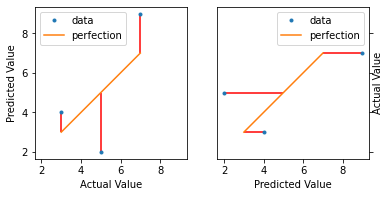

In [144]:
def regression_errors(figsize, predicted, actual, errors='all'):
    ''' figsize -> subplots;
        predicted/actual data -> columns in a DataFrame
        errors -> 'all' or sequence of indices 
    '''
    fig, axes = plt.subplots(1, 2, figsize=figsize,
                             sharex=True, sharey=True)
    df = pd.DataFrame({'actual':actual,
                       'predicted': predicted})
    
    for ax, (x,y) in zip(axes, it.permutations(['actual',
                                                'predicted'])):
        # plot the data as '.'; perfect as y=x line
        ax.plot(df[x], df[y], '.', label='data')
        ax.plot(df['actual'], df['actual'], '-',
               label='perfection')
        ax.legend()
        
        ax.set_xlabel('{} Value'.format(x.capitalize()))
        ax.set_ylabel('{} Value'.format(y.capitalize()))
        ax.set_aspect('equal')
        
    axes[1].yaxis.tick_right()
    axes[1].yaxis.set_label_position('right')
    
    # show connecting bars from data to perfect
    # for all or only those specified?
    if errors == 'all':
        errors = range(len(df))
    if errors:
        acts = df.actual.iloc[errors]
        preds = df.predicted.iloc[errors]
        axes[0].vlines(acts, preds, acts, 'r')
        axes[1].hlines(acts, preds, acts, 'r')
        
regression_errors((6, 3), ape_df.predicted, ape_df.actual)

The orange line is an omnisicient model, where the predicted value is the true actual value.  The error there si zero.  Flipping the axes results in flipping the dataoints over the line $y = x$.  We can apply this to our diabetes dataset. 

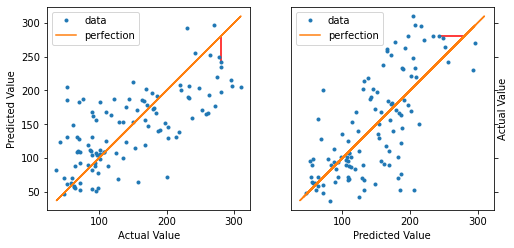

In [145]:
lr = linear_model.LinearRegression()
preds = (lr.fit(diabetes_train_ftrs, diabetes_train_tgt)
           .predict(diabetes_test_ftrs))

regression_errors((8, 4), preds, diabetes_test_tgt, errors=[-20])

The left-hand graph answers the question "compared to reality, how did we do?" The right-hand graph answers, 'for a given prediction, how did we do?'  The difference is similar to that between sensitivity (and specificity) being calcluated with respect to the *reality of sick*, while precision is calculated with respect to a *prediction of sick*.  When the actual value ranges from 200 to 250, we seem to consistently predict low.  When the predicted value is near 200, we have real values ranging from 50 to 300.

## 7.3.2 Residual Plots

We will not talk about *residual plots*.  The error of our predictions can be calculated as follows: $ error = predicted - actual $.  However, for *residual plots* the equation is $ residuals = actual - predicted $.  

In [146]:
ape_df = pd.DataFrame({'predicted' : [4, 2, 9],
                       'actual'    : [3, 5, 7]})
ape_df['error'] = ape_df['predicted'] - ape_df['actual']
ape_df['resid'] = ape_df['actual'] - ape_df['predicted']
ape_df.index.name = 'example'
display(ape_df)
                       

,predicted,actual,error,resid
example,,,,
0,4,3,1,-1
1,2,5,-3,3
2,9,7,2,-2


When talking about *errors* we interpret that value as how much we over- or undershot by.  Any error of 2 means our prediction was over by 2.  We can think about it as *what happened*.  With residuals, we think about what adjustment we need to do to *fix up* our prediction.  A residual of -2 means that we need to subtract 2 to get the right answer.

With residuals, we are thinking about the adjustment we need to do to *fix up* our prediction.  A residual of -2 means that we need to subtract 2 to get to the right answer.

Residual plots are made by graphing the predicted value against the residual for the prediction.  Therefore, we need a slight variation of the right graph above (predicted versus actual) but written in terms of *residuals*, not *errors*.  We will take the residual values, which are the signed distance from predicted back to actual, and graph them against their predicted value.

For example, if we predict 31.5 for an example that is actually 27.5, the residual is -4.0.  So we have a point at (*x* = predicted = 31.5, *y* = residual = -4.0).  These can be thought of as *what's left over after we make a prediction*.  What's left over is sometimes called a *residue.* 

We are making two graphs: (1) actual against predicted and (2) predicted against residual.



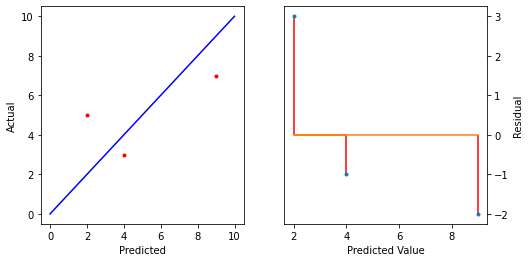

In [164]:
def regression_residuals(ax, predicted, actual,
                         show_errors=None, right=False):
    ''' figsize -> subplots;
        predicted/actual data -> columns of a DataFrame
        errors -> 'all' or sequence of indices
    '''
    df = pd.DataFrame({'actual':actual,
                       'predicted':predicted})
    df['error'] = df.actual - df.predicted
    ax.plot(df.predicted, df.error, '.')
    ax.plot(df.predicted, np.zeros_like(predicted), '-')
    
    if right:
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position('right')
        ax.set_xlabel('Predicted Value')
        ax.set_ylabel('Residual')
        
    if show_errors == 'all':
        show_errors = range(len(df))
    if show_errors:
        preds = df.predicted.iloc[show_errors]
        errors = df.error.iloc[show_errors]
        ax.vlines(preds, 0, errors, 'r')
        
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.plot(ape_df.predicted, ape_df.actual, 'r.', # pred vs actual
         [0, 10], [0, 10], 'b-')              
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
regression_residuals(ax2, ape_df.predicted, ape_df.actual,
                    'all', right=True)

In [163]:
regression_residuals(ax, preds, diabetes_test_tgt, [0,10,20,30,35,36], on_right)

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

Now, we can compare two different learners based on their residual plots.   We can use a proper train-test split, so these residuals are called *predictive residuals*.  In a traditional stats class, the plain vanilla residuals are computed from the training set (sometimes called *in sample*).  That's not our normal method for evaluation: we prefer to evaluate against a test set.  

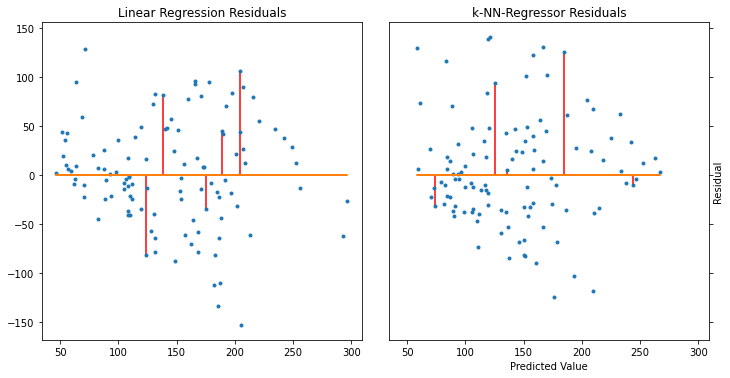

In [148]:
lr = linear_model.LinearRegression()
knn = neighbors.KNeighborsRegressor()

models = [lr, knn]
fig, axes = plt.subplots(1, 2, figsize=(10, 5),
                         sharex=True, sharey=True)
fig.tight_layout()

for model, ax, on_right in zip(models, axes, [False, True]):
    preds = (model.fit(diabetes_train_ftrs, diabetes_train_tgt)
                  .predict(diabetes_test_ftrs))
    
    regression_residuals(ax, preds, diabetes_test_tgt, [0,10,20,30,35,36], on_right)
    
axes[0].set_title('Linear Regression Residuals')
axes[1].set_title('k-NN-Regressor Residuals');

Since the two models predict different values for our point of interest, it shows up at different spots on the horizontal *x* axis.  With linear regression, the value is predicted a hint under 250.  With the *k*-NN-R model, the value is predicted to be a bit above 250.  In both cases, it is underpredicted.  Remeber, residuals tell us how to fix up the prediction.  We need to ADD a bit to these predictions).  Teh actual value is:

In [149]:
print(diabetes_test_tgt[-20])

280.0


In [150]:
diabetes_test_tgt

array([219.,  70., 202., 230., 111.,  84., 242., 272.,  94.,  96.,  94.,
       252.,  99., 297., 135.,  67., 295., 264., 170., 275., 310.,  64.,
       128., 232., 129., 118., 263.,  77.,  48., 107., 140., 113.,  90.,
       164., 180., 233.,  42.,  84., 172.,  63.,  48., 108., 156., 168.,
        90.,  52., 200.,  87.,  90., 258., 136., 158.,  69.,  72., 171.,
        95.,  72., 151., 168.,  60., 122.,  52., 187., 102., 214., 248.,
       181., 110., 140., 202., 101., 222., 281.,  61.,  89.,  91., 186.,
       220., 237., 233.,  68., 190.,  96.,  72., 153.,  98.,  37.,  63.,
       184., 144., 150., 280., 125.,  59.,  65., 281., 277., 167.,  90.,
        72., 178.,  88., 270., 101., 197.,  97.,  53.,  71., 262.,  52.,
       102.])

If either model predicted 280, the residual would be zero.  In classicial stats, when looking at the residual plots, you are trying to diagnose if the assumptions of linear regression are violated.  However, here we use linear regression as a black box prediction method.  therefore, we are concerned about trends among the residual s with respect to the predicted values.  Potential trends are what these graphs give us a chance to evaluate.  At the low end of the predicted values for the linear regression model, we have pretty consistent **negative error** (*positive residual*).  This means that when we predict a small value, we are undershooting.  We also see undershooting in the predicted values around 200 to 250.  

For *k*-NN-R, there is a wider spread among the negative errors, while the positive errors are more clumped around the zero error line.  

# 7.4 A First Look at Standardization

Broadly, when normalzing, we take different measurements and put them directly on comparable footing.  This often involves two steps: (1) adjusting the center of the data and (2) adjusting the scale of the data.

Some learning methods *require* normalization before we can reasonably press 'Go!'.  Second we are using a common form of normalization called *standardization*.  When we *standardize* our data, we do two things: (1) we *center* the data around zero and (2) we scale the data so it has a standard deviation of 1.  To acommplish this we do two things (1) subtract the mean and (2) divide by the standard deviation.  

The standard deviation is a close friend of variance.  We get standard deviation by taking the square root of variance.  

,x,std-ized
mean,2.5000,0.0000
std,4.6706,1.0000


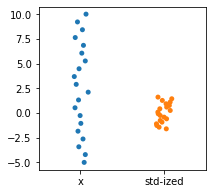

In [151]:
# 1D standardization
# place evenly spaced values in a dataframe
xs = np.linspace(-5, 10, 20)
df = pd.DataFrame(xs, columns=['x'])

# center ( - mean) and scale (/ std)
df['std-ized'] = (df.x - df.x.mean()) / df.x.std()

# show original and new data; compute statistics
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sns.stripplot(data=df)
display(df.describe().loc[['mean', 'std']])


That's all well and good, things get far more interesting in two dimensions:

In [152]:
# 2 1d standardizations
xs = np.linspace(-5, 10, 20)
ys = 3*xs + 2 + np.random.uniform(20, 40, 20)
print(xs)
print(ys)

[-5.     -4.2105 -3.4211 -2.6316 -1.8421 -1.0526 -0.2632  0.5263  1.3158
  2.1053  2.8947  3.6842  4.4737  5.2632  6.0526  6.8421  7.6316  8.4211
  9.2105 10.    ]
[ 9.043  22.5423 30.5935 30.2829 18.002  24.4295 39.8169 28.6401 41.5708
 44.8184 40.5933 40.7796 44.4235 42.3288 57.9457 51.5387 62.5439 49.377
 69.3971 60.8655]


In [153]:
df = pd.DataFrame({'x':xs, 'y':ys})
df

,x,y
0,-5.0000,9.0430
1,-4.2105,22.5423
2,-3.4211,30.5935
3,-2.6316,30.2829
4,-1.8421,18.0020
5,-1.0526,24.4295
6,-0.2632,39.8169
7,0.5263,28.6401
8,1.3158,41.5708
9,2.1053,44.8184


In [154]:
df_std_ized = (df - df.mean()) / df.std()
df_std_ized

,x,y
0,-1.6058,-1.9987
1,-1.4368,-1.1404
2,-1.2677,-0.6284
3,-1.0987,-0.6482
4,-0.9297,-1.4290
5,-0.7606,-1.0204
6,-0.5916,-0.0419
7,-0.4226,-0.7526
8,-0.2535,0.0696
9,-0.0845,0.2761


In [155]:
df_std_ized.describe()

,x,y
count,20.0000,20.0000
mean,0.0000,0.0000
std,1.0000,1.0000
min,-1.6058,-1.9987
25%,-0.8029,-0.6743
50%,0.0000,0.0444
75%,0.8029,0.6003
max,1.6058,1.8389


In [156]:
display(df_std_ized.describe().loc[['mean', 'std']])

,x,y
mean,0.0000,0.0000
std,1.0000,1.0000


We can look at the original data and the standardized data on two different scales: the natural scale that `matplotlib` wants to use for the data and a simple, fixed, zoomed-out scale:

Text(0.5, 0, 'Standardized Data')

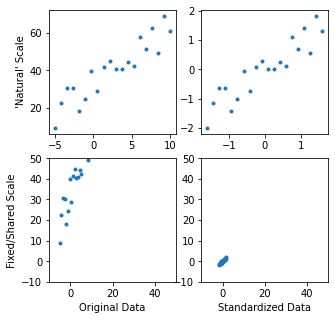

In [157]:
fig, ax = plt.subplots(2, 2, figsize=(5, 5))

ax[0,0].plot(df.x, df.y, '.')
ax[0,1].plot(df_std_ized.x, df_std_ized.y, '.')
ax[0,0].set_ylabel("'Natural' Scale")

ax[1,0].plot(df.x, df.y, '.')
ax[1,1].plot(df_std_ized.x, df_std_ized.y, '.')

ax[1,0].axis([-10, 50, -10, 50])
ax[1,1].axis([-10, 50, -10, 50])

ax[1,0].set_ylabel('Fixed/Shared Scale')
ax[1,0].set_xlabel('Original Data')
ax[1,1].set_xlabel('Standardized Data')

After standardizing, the shape of the data stays the same.  You can clearly see this in the top row--where the data are on different scales and in different locations.  

In the top row, `matplotlib` uses different scales to empasize the data's *shape*.  In the bottom row, a fixed common scale emphasize that the *location* and the *spread* of the data are different.  Standardizing shifts the data to be centered at zero and scales the data so that the resulting values have a standard deviation and variance of 1.0.

We can perform standarization in `sklearn` using a special 'learner' named `StandardScaler`.  The learner figures out the mean and standard deviation from the training data and applies these values to transform the traing or test data.  The name of this in `sklearn` is *Transformer*.  `fit` works the same way as it does for the learners we've seen so far.  

However, instead of `predict`, we use `transform`.


In [158]:
train_xs, test_xs = skms.train_test_split(xs.reshape(-1, 1), test_size=.5)
print(train_xs)
print(test_xs)
scaler = skpre.StandardScaler()
scaler.fit(train_xs).transform(test_xs)

[[ 6.0526]
 [ 5.2632]
 [ 8.4211]
 [-3.4211]
 [ 9.2105]
 [-5.    ]
 [ 2.8947]
 [10.    ]
 [ 4.4737]
 [ 0.5263]]
[[-1.0526]
 [ 2.1053]
 [-0.2632]
 [ 3.6842]
 [ 7.6316]
 [-4.2105]
 [ 1.3158]
 [-2.6316]
 [-1.8421]
 [ 6.8421]]


array([[-1.0037],
       [-0.3561],
       [-0.8418],
       [-0.0324],
       [ 0.777 ],
       [-1.6512],
       [-0.518 ],
       [-1.3274],
       [-1.1655],
       [ 0.6151]])

Now, we will talk about pipelines, where we can standardize and then fit in a model in one condensed package.

In [159]:
(train_xs, test_xs,
 train_ys, test_ys) = skms.train_test_split(xs.reshape(-1, 1),
                                            ys.reshape(-1, 1),
                                            test_size=.5)
xs

array([-5.    , -4.2105, -3.4211, -2.6316, -1.8421, -1.0526, -0.2632,
        0.5263,  1.3158,  2.1053,  2.8947,  3.6842,  4.4737,  5.2632,
        6.0526,  6.8421,  7.6316,  8.4211,  9.2105, 10.    ])

In [160]:
scaler = skpre.StandardScaler()
lr = linear_model.LinearRegression()

std_lr_pipe = pipeline.make_pipeline(scaler, lr)

std_lr_pipe.fit(train_xs, train_ys).predict(test_xs)

array([[19.5999],
       [64.8115],
       [58.3527],
       [16.3705],
       [13.1411],
       [71.2703],
       [45.4351],
       [35.7469],
       [48.6645],
       [ 9.9117]])

The pipline acts just like any other learner we've seen: it has `fit` and `predict` methods.  We can use a pipeline as a plug-in substitute for any other learning method.  

We use the *same interface* whether the learners are stand-alone components or built up from primitive components.  

Even though the `StandardScaler` uses `transform` when it is applied stand-alone, the overall pipeline uses `predict` to apply the transformation.  Calling `my_pipe.predict()` will do the transformations necessary to get to the final product without having to explicity call the `transform` step.

You may have noticed we are learning the parameters we use to standardize (our training mean and standard deviation).
We do that from the *training* set.  We do not want to peek with a learning model, we also don't want to peek with our preprocessing.  

Never peek at the test data unless there is (1) a formal proof that peeking won't bias or invalidate your results and (2) you understand the limits of the formal proof and when it may *not* apply, so that again, you're back in a scenario wher you shouldn't peek.


# 7.5 Evaluating Regressors in a More Sophisticated Way: Take Two

We not turn back to the Portuguese student data for a larger example.  We have the same data we used in Chapter 6, except we keep the target feature as a numerical value.  

Therefore, we just have the numerical features from the original dataset and the`G3` column as our target.

In [161]:
student_url = ('https://archie.ics.uci.edu/' +
               'ml/machine-learning-databases/00320/student.zip')
def grab_student_numeric():
    # download zip file and un

IndentationError: expected an indented block (<ipython-input-161-a0fb6c0d288d>, line 4)

In [ ]:
df = pd.read_csv('student-mat.csv', sep=';')
student_df = df.drop(columns=['G1', 'G2']).select_dtypes(include=['number'])
df

In [ ]:

display(student_df[['absences']].describe().T)
student_df

In [ ]:
student_ftrs = student_df[student_df.columns[:-1]]
student_tgt = student_df['G3']

## 7.5.1 Cross-Validated Results on Multiple Metrics

The following uses `skms.cross_validate` to score over multiple metrics.  

It is a nice convenience function that allows us to evaluate multiple metrics with one call.  It works to capture the amount of time spent to fit and predict with the given model.

We will ignore those pieces and just make use of the multiple metric evaluations that it returns.

Like `skms.cross_val_score`, it requires `scoreres` passed into the `scoring` argument.

In [ ]:
scaler = skpre.StandardScaler()

lr = linear_model.LinearRegression()
knn_3 =  neighbors.KNeighborsRegressor(n_neighbors=3)
knn_10 = neighbors.KNeighborsRegressor(n_neighbors=10)

std_lr_pipe = pipeline.make_pipeline(scaler, lr)
std_knn3_pipe = pipeline.make_pipeline(scaler, knn_3)
std_knn10_pipe = pipeline.make_pipeline(scaler, knn_10)

# mean with/without Standardization should give some results
regressors = {'baseline'  : dummy.DummyRegressor(strategy='mean'),
              'std_knn3'  : std_knn3_pipe,
              'std_knn10' : std_knn10_pipe, 
              'std_lr'    : std_lr_pipe}

msrs = {'MAE'  : metrics.make_scorer(metrics.mean_absolute_error),
        'RMSE' : metrics.make_scorer(rms_error)}

fig, axes = plt.subplots(2, 1, figsize=(6, 4))
fig.tight_layout()
for mod_name, model in regressors.items():
    cv_results = skms.cross_validate(model,
                                     student_ftrs, student_tgt,
                                     scoring = msrs, cv=10)
    for ax, msr in zip(axes, msrs):
        msr_results = cv_results['test_' + msr]
        my_lbl = f'{mod_name:12s} {msr_results.mean():.3f} {msr_results.std():.2f}'
        
        ax.plot(msr_results, 'o--', label=my_lbl)
        ax.set_title(msr)
        ax.legend(bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True) # uncomment for summary stats

3-NN is not serving us very well in this problem: the baseline method generally has less error than 3-NN.  For several folds, 10-NN and LR perform very similar and their overall performance is mostly on par with on another and slightly better than baseline.  We can tease out some of the close values--and get a more direct comparison with the baseline regressor, by looking at the ratio of $MSEs = \frac{\sqrt{MSE_{me}}}{\sqrt{MSE_{baseline}}} $.

In [ ]:
fig,ax = plt.subplots(1, 1, figsize=(6,3))
baseline_results = skms.cross_val_score(regressors['baseline'],
                                        student_ftrs, student_tgt,
                                        scoring = msrs['RMSE'], cv=10)

for mod_name, model in regressors.items():
    if mod_name.startswith('std_'):
        cv_results = skms.cross_val_score(model,
                                          student_ftrs, student_tgt,
                                          scoring = msrs['RMSE'], cv=10)
        my_lbl= f'{mod_name:12s} {cv_results.mean():.3f} {cv_results.std():.2f}'
        
        ax.plot(cv_results / baseline_results, 'o--', label=my_lbl)
ax.set_title('RMSE(model) / RMSE(baseline)\n$<1$ is better than baseline')
ax.legend(bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)

Here, it is clear that 3-NN is generating more error than baseline since its ratios are bigger than 1 and it is worse than the other two regressors.  We see that LR seems to be a bit of awinner on more folds, although 10-NN does eek out a few victories in folds 6-9.

Let's see the default $R^2$ scoring for this problem, although it is easily abused.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
for mod_name, model in regressors.items():
    cv_results = skms.cross_val_score(model,
                                      student_ftrs, student_tgt,
                                      cv=10)
    my_lbl = f'{mod_name:12s} {cv_results.mean():.3f} {cv_results.std():.2f}'
    
    ax.plot(cv_results, 'o--', label=my_lbl)
ax.set_title('$R^2$')
ax.legend(fancybox=True, shadow=True, bbox_to_anchor=(1, 0.5))

There are two interesting patterns here.  Linear regression is consistently better than *k*-NN-R.  The *order* of the winnders on each fold seems to be the same.  

Why doesn't the baseline model, which has a mean predictor model, have an $R^2$ value of zero?

There's going to be different values for the means of training and testing sets.  We are doing train-test splitting wrapped up in cross-validation, our training and testing means are going to be a bit off from each other, but not too much.  You'll notice that most of the $R^2$ values for the baseline mare are in the vicinity of zero.  That's the price we pay for randomness and using $R^2$. 

# 7.5.2 Summarizing Cross-Validated Results

Another approach to cross-validated predictions is to view the entire cross-validation process as a single learner.  Remember, each example is in *one and only one* testing scenario in cross-validation.  Therefore, we can simply gather up all the predictions, made by a basket of learners training on different partitions of the data, and compare them with our known targets.  

Applying an evaluation metric to these predictions and targets gives us a net result of a *single* value for each model and metric.  We access the predictions with `cross_val_predict.`

In [ ]:
msrs = {'MAE'  : metrics.mean_absolute_error,
        'RMSE' : rms_error} # not scorer, no model

results = {}
for mod_name, model in regressors.items():
    cv_preds = skms.cross_val_predict(model,
                                      student_ftrs, student_tgt,
                                      cv=10)
    for ax, msr in zip(axes, msrs):
        msr_results = msrs[msr](student_tgt, cv_preds)
        results.setdefault(msr, []).append(msr_results)
        
df = pd.DataFrame(results, index=regressors.keys())
df

In [ ]:
msr_results

# 7.5.3 Residuals


Let's look at (1) the residuals of our baseline model and (2) using the standardized, preprocessed data.

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(10, 5),
                         sharex=True, sharey=True)
fig.tight_layout()
for model_name, ax in zip(regressors, axes):
    model = regressors[model_name]
    preds = skms.cross_val_predict(model,
                                   student_ftrs, student_tgt,
                                   cv=10)
    
    regression_residuals(ax, preds, student_tgt)
    ax.set_title(model_name + ' residuals')
pd.DataFrame(student_tgt).describe().T

Key points:

* Even though we are using the mean model as our baseline model, we have multiple means, one mean for each training-split.  Our predicted values only have a slight variation for the mean-only models(s)

* The residuals for our standardize-then-fit models have some striking patterns.

    1. They all show banding.  The banding is due to the integer values of the target: there are target values of 17 and 18, but not 17.5.  Therefore, there are distinct gaps.
    2. The overall patterns seem quite similar for each nonbaseline model.
    3. There's a whole band of 'error outliers' where all of the residuals are negative and keep decreasing with the amount of the prediction.  Negative residuals are positive errors.  It indicates that we are overpredicting.  On the right, we predict 15, and we are over by about 15, as the actual is near zero.  On the left, we predict 5 and we've over by about 5, the actual is, again, near zero.  So the *reason* we see that band is that it shows us our *maximum* error (minimum residual) at each possible predicted value.  If we predict *x* and the actual value is zero, our error is *x* (residual of -*x*).

# 7.6 EOC

## 7.6.1 

We added (1) baseline regression models, (2) residual plots, and (3) some appropriate metrics.  We also looked at pipelines and standardization and discussed some of the difficulties of the metrics above.